In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
from pathlib import Path
import numpy as np
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
# Configuration
BATCH_SIZE = 8
IMAGE_SIZE = 128  # Reduced from 224 to save memory
CHANNELS = 3
EPOCHS = 30  # Reduced to balance training time and accuracy
DATASET_PATH = Path("/content/drive/MyDrive/PlantVillage")

In [3]:
import shutil
import os
from pathlib import Path

# Define source and destination paths
SOURCE_PATH = Path("/content/drive/MyDrive/PlantVillage")
LOCAL_PATH = Path("/content/PlantVillage_local")

# Create local directory if it doesn't exist
if not os.path.exists(LOCAL_PATH):
    os.makedirs(LOCAL_PATH)

# Copy dataset to local disk if not already copied
if not any(os.listdir(LOCAL_PATH)):
    print(f"Copying dataset from {SOURCE_PATH} to {LOCAL_PATH}...")
    shutil.copytree(SOURCE_PATH, LOCAL_PATH, dirs_exist_ok=True)
    print("Dataset copied successfully!")
else:
    print(f"Dataset already exists at {LOCAL_PATH}")

# Update dataset path to local copy
DATASET_PATH = LOCAL_PATH

Copying dataset from /content/drive/MyDrive/PlantVillage to /content/PlantVillage_local...
Dataset copied successfully!


In [10]:
# Load dataset
if os.path.exists(DATASET_PATH):
    print(f"Found dataset at: {DATASET_PATH}")
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        DATASET_PATH,
        seed=123,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )
    # Get class names before converting to float16
    class_names = dataset.class_names
    print("Class names:", class_names)
    num_classes = len(class_names)
    # Convert dataset to float16
    dataset = dataset.map(lambda x, y: (tf.cast(x, tf.float16), y))
else:
    print(f"Error: Dataset not found at {DATASET_PATH}")
    print("Please check the path and ensure the dataset is extracted correctly.")

Found dataset at: /content/PlantVillage_local
Found 16011 files belonging to 10 classes.
Class names: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [7]:
# Get class names
# class_names = dataset.class_names # This line is no longer needed here
# print("Class names:", class_names) # This line is no longer needed here
# num_classes = len(class_names) # This line is no longer needed here

AttributeError: '_MapDataset' object has no attribute 'class_names'

In [11]:
# Dataset partitioning
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

# Cache, shuffle, and prefetch to optimize performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Delete original dataset variable to free up memory
del dataset

In [12]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255)
])

In [13]:
# Build lightweight CNN model
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Delete augmentation and preprocessing layers to free up memory
del resize_and_rescale
del data_augmentation

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Delete history to free up memory after training
del history

Epoch 1/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.3838 - loss: 1.7362 - val_accuracy: 0.7444 - val_loss: 0.7318
Epoch 2/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 62s 13ms/step - accuracy: 0.7268 - loss: 0.8195 - val_accuracy: 0.8175 - val_loss: 0.4938
Epoch 3/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7877 - loss: 0.6330 - val_accuracy: 0.8350 - val_loss: 0.4470
Epoch 4/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8208 - loss: 0.5272 - val_accuracy: 0.8231 - val_loss: 0.4832
Epoch 5/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - accuracy: 0.8473 - loss: 0.4430 - val_accuracy: 0.9219 - val_loss: 0.2238
Epoch 6/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8643 - loss: 0.4076 - val_accuracy: 0.8975 - val_loss: 0.2988
Epoch 7/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8821 - loss: 0.3557 - val_accuracy: 0.9212 - val_loss: 0.2441
Epoch 8/30
1601/1601 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.8878 -

In [14]:
# Evaluate model
scores = model.evaluate(test_ds)
print(f"Test accuracy: {scores[1]*100:.2f}%")

# Delete scores to free up memory after evaluation
del scores

188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.9372 - loss: 0.1582
Test accuracy: 93.82%


In [16]:
# Prediction function
def predict(model, img):
    img_array = tf.expand_dims(img, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

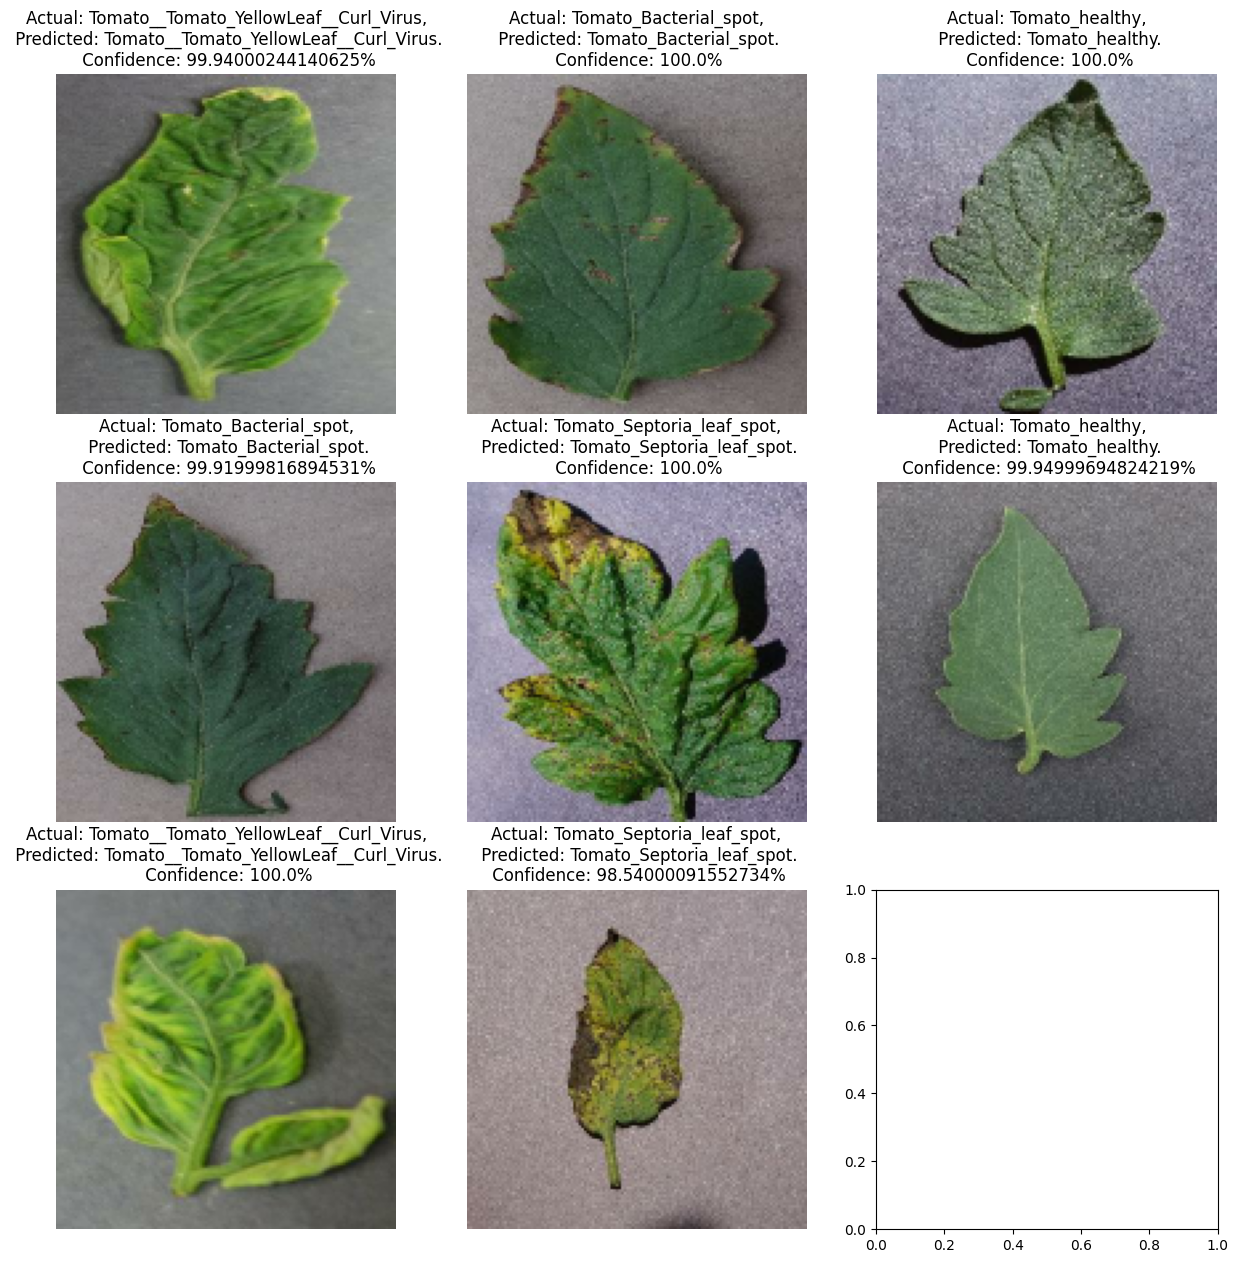

In [17]:
# Visualize predictions
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
plt.show()

In [15]:
# Save model
model.save('tomato_disease_classifier.keras')
from google.colab import files
files.download('tomato_disease_classifier.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>